In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange

from IPython.display import clear_output


In [2]:
n_bytes = 156#128


def save_preset(data, fname):
    newFile = open(fname, "wb")
    newFileByteArray = bytearray(data.tobytes())
    newFile.write(newFileByteArray)
    
def preprocess_data(data, method="normalization"):
    
    orig = np.copy(data)
        
    maxs = data.max(axis=0)
        
    if method == "normalization": # get values between 0 and 1
        assert maxs.shape == (n_bytes,)
        data = data/maxs # normalize
        
    else:
        print("Unknown preprocessing method")
        
    
    for i in range(10):
        save_preset(np.array(data[i]*maxs, dtype=int), "test/orig_"+str(i)+".syx")
        save_preset(np.array(orig[i], dtype=int), "test/proc_"+str(i)+".syx")
    
    print(orig[i])
    print(np.array(data[i]*maxs, dtype=int))
    return data, maxs


class PresetDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def load_data(fname, preprocess=None):
    
    with open(fname, 'rb') as f:
        data = bytearray(f.read()) # open the largest existing dataset of unique DX7 voices (from https://github.com/bwhitman/learnfm)

    data = np.array(data)
    data = data.reshape((-1,n_bytes)) # each voice is encoded in 128 bytes
    print("The dataset contains "+str(data.shape[0])+" voices")
    if preprocess is not None:
        data = preprocess_data(data, preprocess)
        
    return data




In [3]:
def fc_layer(D_in, D_out):
    layers = ()
    layers += (nn.Linear(D_in, D_out),)
    #layers += (nn.BatchNorm1d(num_features=D_out))
    layers += (nn.LeakyReLU(0.05),)
    return nn.Sequential(*layers)    

class Coder(nn.Module) :
    def __init__(self, D_in, D_h_list, D_out, output_activation=None) :
        super(Coder,self).__init__()
        
        self.layers = ()
        
        for i in range(len(D_h_list)):
            self.layers += (fc_layer(D_in, D_h_list[i]),)
            D_in = D_h_list[i]
        
        self.layers += (nn.Linear(D_in, D_out),)
        
        assert output_activation is None or output_activation in ["sigmoid","LeakyReLU"]
        if output_activation == "sigmoid":
            print("sigmoid")
            self.layers += (nn.Sigmoid(),)
        elif output_activation == "LeakyReLU":
            self.layers += (nn.LeakyReLU(.05),)
            
        self.layers = nn.Sequential( *self.layers)
        print(self.layers)

    def forward(self,z):
        return self.layers(z)


class betaVAE(nn.Module) :
    def __init__(self, D_x, D_h, D_z, beta=1.0, use_cuda=True) :
        super(betaVAE,self).__init__()
        print("encoder")
        self.encoder = Coder(D_x, D_h, D_z*2, output_activation=None)
        print("decoder")
        self.decoder = Coder(D_z, D_h[::-1], D_x, output_activation="sigmoid")
        self.beta = beta
        self.use_cuda = use_cuda

        if self.use_cuda :
            self = self.cuda()

    def reparameterize(self, mu, log_var) :
        eps = torch.randn((mu.size()[0], mu.size()[1]))
        veps = Variable(eps)
        #veps = Variable( eps, requires_grad=False)
        if self.use_cuda:
            veps = veps.cuda()
        z = mu + veps * torch.exp(log_var/2)
        return z

    def forward(self,x) :
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, log_var)
        out = self.decoder(z)

        return out, mu, log_var





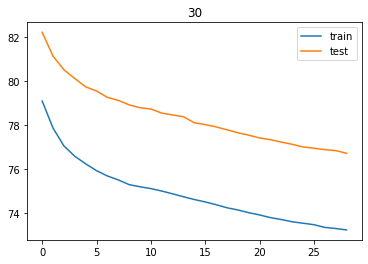

KeyboardInterrupt: 

In [4]:

# Model :
D_x = n_bytes
D_h = [800]
D_z = 20
use_cuda = False
beta = 1
vae = betaVAE(D_x, D_h, D_z, beta, use_cuda).float()

# Optim :
lr = 10e-5
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
batch_size = 400

# Data :
ds_proportions_bounds = (.7,.85,1)
data, maxs = load_data('../data_extraction/unpacked.bin', 'normalization')
n_data = len(data)
datasets = {}
datasets['train'] = PresetDataset(data[:int(n_data*ds_proportions_bounds[0])])
datasets['test'] = PresetDataset(data[int(n_data*ds_proportions_bounds[0]):int(n_data*ds_proportions_bounds[1])])
datasets['validate'] = PresetDataset(data[int(n_data*ds_proportions_bounds[1]):int(n_data*ds_proportions_bounds[2])])
print("Dataset sizes: "+str([len(datasets[k]) for k in datasets.keys()]))

loaders = {k: DataLoader(dataset=datasets[k], batch_size=batch_size, shuffle=True) for k in datasets.keys()}

datasets['save_presets'] = PresetDataset(data[:int(n_data*ds_proportions_bounds[0])])
loaders['save_presets'] = DataLoader(dataset=datasets['save_presets'], batch_size=1, shuffle=False)


loss_history = {k:[] for k in ['train','test','validate']}

for epoch in trange(100, desc="epochs"):
    
    loss_history['train'].append(0)
    loss_history['test'].append(0)
    
    for i, presets in enumerate(loaders['train']):
        if use_cuda :
            presets = presets.cuda() 
        presets = presets.view(-1, D_x).float()
        out, mu, log_var = vae(presets)
        reconst_loss = F.binary_cross_entropy(out, presets, reduction='sum')
        kl_divergence = torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var -1))
        total_loss = reconst_loss + vae.beta * kl_divergence
        loss_history['train'][-1] += total_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
    loss_history['train'][-1] /= i*batch_size
    
    presets_to_test = np.random.randint(len(presets))
    print(presets[presets_to_test])
    print(out[presets_to_test])
    print('\n')
        
    for i, presets in enumerate(loaders['test']):
        if use_cuda :
            presets = presets.cuda() 
        presets = presets.view(-1, D_x).float()
        out, mu, log_var = vae(presets)
        reconst_loss = F.binary_cross_entropy(out, presets, reduction='sum')
        kl_divergence = torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var -1))
        total_loss = reconst_loss + vae.beta * kl_divergence
        loss_history['test'][-1] += total_loss
        
    loss_history['test'][-1] /= i*batch_size
        
    clear_output()
    plt.title(str(epoch))
    plt.plot(loss_history['train'][2:], label='train')
    plt.plot(loss_history['test'][2:], label='test')
    plt.legend()
    plt.show()
    
    
    
        




In [5]:

for i, presets in enumerate(loaders['save_presets']):
    if i>50:
        break
    if use_cuda :
        presets = presets.cuda() 
    presets = presets.view(-1, D_x).float()
    out, mu, log_var = vae(presets)
    
    save_preset(np.array(presets[0] * maxs, dtype=int), "out/"+str(i)+'.syx')
    save_preset(np.array(out.detach()[0] * maxs, dtype=int), "out/"+str(i)+'_reconstructed.syx')
    
        
        




In [ ]:
data, maxs = load_data('../data_extraction/unpacked.bin', 'normalization')
datasets['save_presets'] = PresetDataset(data[:5])
loaders['save_presets'] = DataLoader(dataset=datasets['save_presets'], batch_size=1, shuffle=False)

for i, presets in enumerate(loaders['save_presets']):
    if i>0:
        break
